In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()

In [3]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [4]:
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()

In [22]:
''' 
rebin impact data to match the structure of the hists_all() bin structure
'''

def rebin_temp_data_mortalty(da):
    
    #creates new edges of the bins from >10, 10-100, <100, in intervals of 10F. Then, calculate the midpoints of the bins 
    edges_F = np.concatenate(([-np.inf], np.arange(10, 100, 10), [np.inf]))
    mid_F = (edges_F[:-1] + edges_F[1:]) / 2
    
    mort_coeffs = [0.69,0.59,0.64,0.36,0.27,0.00,0.12,0.23,0.33,0.94]
    
    #creates an array with the mortality coeffs, and labels the 1D dim 'bin10F'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in farenheit. Names the array.
    dmgf_10F = xr.DataArray(mort_coeffs, dims=['bin10F'], coords={'bin10F':np.arange(10), 'mid_F_degF': ('bin10F', mid_F)},
    name='mortality_coeff')
    
    #grabs bins from ds and converts to F
    hist_bins_F = da['bin_f'].values * 9/5 - 459.67
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_F, edges_F) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin10F dimension the coeff that matches the integer 
    #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_10F.sel(bin10F = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine
    

In [33]:
def rebin_temp_data_gdp(da):
    
    #creates new edges of the bins from >-15, -15-31, <31, in intervals of 3C. Then, calculate the midpoints of the bins 
    edges_C = np.concatenate(([-np.inf], np.arange(-15, 31, 3), [ np.inf ]))
    mid_C   = (edges_C[:-1] + edges_C[1:]) / 2
    
    gdp_coeffs = [0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                    0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757]
    
    #creates an array with the gdp coeffs, and labels the 1D dim 'bin3C'. Then, attaches two coordinates,
    #one with just integer labels, and one that denotes the actual midpoints in C. Names the array.
    dmgf_dnh_3C = xr.DataArray(gdp_coeffs,dims=['bin3C'],coords={'bin3C':np.arange(len(gdp_coeffs)),'mid_C_degC': ('bin3C', mid_C)},name='gdp_loss_coeff')

    #grabs bins from ds and converts to C
    hist_bins_C = da['bin_f'].values - 273.15
    
    #maps each bin from the original data to the new coarse bins and assigns an integer count for which bin it belongs to
    hist_to_coarse_indicies = np.digitize(hist_bins_C, edges_C) - 1
    
    #Creates a data array from the 22-bins of the hist coarse data integers and wraps the integer index array into a 1-D 
    #array with dim bin_f. Then, selects from the damage function along the bin3C dimension the coeff that matches the integer 
    #this new hist now has an associated coefficient with each bin
    hist_fine = dmgf_dnh_3C.sel(bin3C = xr.DataArray(hist_to_coarse_indicies, dims='bin_f'))
    
    return hist_fine

In [31]:
#create empty lists to put mort data in
mort_impact_list = []
gdp_impact_list = []
model_labels   = []

for i, row in df.iterrows():
    
    model_labels.append(row['model'])  
    ds = xr.open_zarr(row['path'])  
    
    gwl_2  = ds['bins_behrer'].sel(gwl=2.0,  method='nearest').transpose('bin_f','lat','lon')
    gwl_06 = ds['bins_behrer'].sel(gwl=0.61, method = 'nearest').transpose('bin_f','lat', 'lon')
    
    diff = gwl_2 - gwl_06
    
    mort_coef_fine = rebin_temp_data_mortality(diff)
    mort_map = (diff * mort_coef_fine).sum(dim='bin_f')
    mort_impact_list.append(mort_map)
    
    gdp_coef_fine = rebin_temp_data_gdp(diff)
    gdp_map = (diff * gdp_coef_fine).sum(dim='bin_f')
    gdp_impact_list.append(gdp_map)

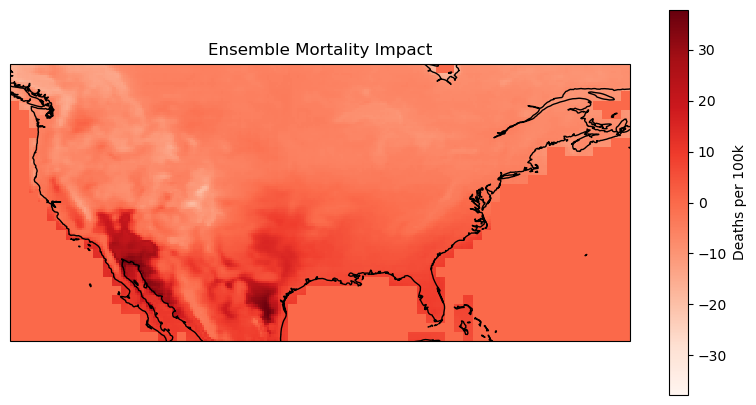

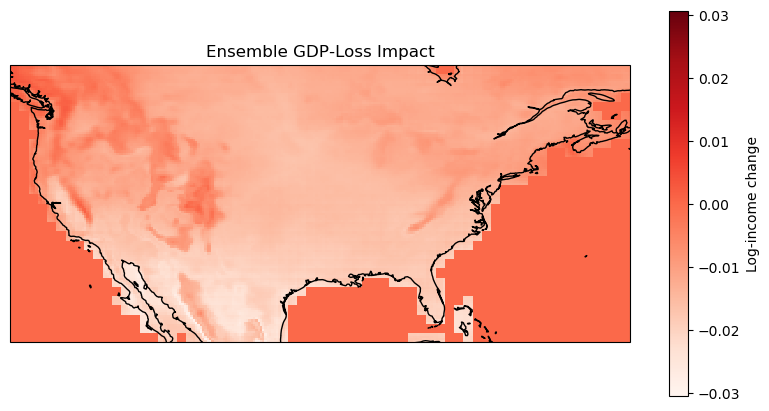

In [32]:
mort_all = xr.concat(mort_impact_list, dim='model')
mort_all = mort_all.assign_coords(model=model_labels)
ensemble_mort = mort_all.mean(dim='model')

gdp_all = xr.concat(gdp_impact_list, dim='model')
gdp_all = gdp_all.assign_coords(model=model_labels)
ensemble_gdp = gdp_all.mean(dim='model')

def plot_map(data, title, cbar_label):
    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': cbar_label})
    ax.coastlines()
    ax.set_title(title)
    plt.show()
    
    
plot_map(ensemble_mort, "Ensemble Mortality Impact", "Deaths per 100k")
plot_map(ensemble_gdp, "Ensemble GDP‐Loss Impact", "Log‐income change")